In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors

import seaborn as sns
import scanpy as sc
#import torch
#sys.path.append('/home/exx/git/Tangram/')  # uncomment for local import
import tangram as tg
import ncem

%load_ext autoreload
%autoreload 2
%matplotlib inline

tg.__version__

'1.0.0'

In [2]:
datadir = '/storage/groups/ml01/workspace/anna.schaar/ncem/data/'

# Loading spatial dataset

In [3]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=datadir + 'lu/',
    data_origin='luwt',
    radius=200,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

merfish_adata = interpreter.data.celldata.copy()

INFO:root:Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/about?format=text`


Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:01<00:00, 130.20it/s]

Loaded 140 images with complete data from 1 patients over 40864 cells with 132 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 16.576537

 Celldata metadata: {'lateral_resolution': 0.1079, 'fn': 'FinalClusteringResults 190517 WT.csv', 'image_col': 'FOV', 'pos_cols': ['Center_x', 'Center_y'], 'cluster_col': 'CellTypeID_new', 'cluster_col_preprocessed': 'CellTypeID_new_preprocessed'}


In [4]:
ad_sp = interpreter.data.celldata.copy()
ad_sp.obs['x'] = ad_sp.obsm['spatial'][:,0]
ad_sp.obs['y'] = ad_sp.obsm['spatial'][:,1]

         Falling back to preprocessing with `sc.pp.pca` and default params.


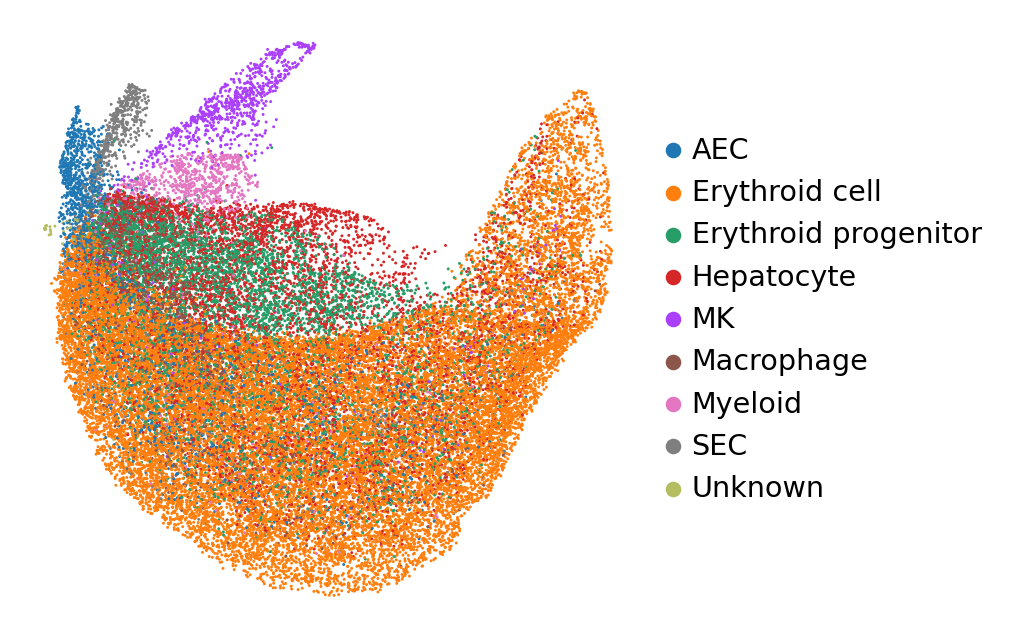

In [31]:
sc.pp.neighbors(ad_sp)
sc.tl.umap(ad_sp)

# Colorblindness adjusted vega_10
# See https://github.com/theislab/scanpy/issues/387
vega_10 = list(map(colors.to_hex, cm.tab10.colors))
vega_10_scanpy = vega_10.copy()
vega_10_scanpy[2] = '#279e68'  # green
vega_10_scanpy[4] = '#aa40fc'  # purple
vega_10_scanpy[8] = '#b5bd61'  # kakhi


plt.ioff()
sc.set_figure_params(scanpy=True, fontsize=14)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
)
sc.pl.umap(
    ad_sp, color='CellTypeID_new_preprocessed', ax=ax, size=7, show=False, title="", 
    palette=vega_10_scanpy, frameon=False
)
#plt.savefig('/storage/groups/ml01/workspace/anna.schaar/ncem/figures/sanity_check/' + 'umap_imputed.pdf')
plt.show()

In [5]:
print(np.min(ad_sp.X), np.max(ad_sp.X))

0.0 515.0


# Loading scRNAseq dataset

In [6]:
data_file = "GSM5242402_E14.5FL_matrix.mtx"
gene_file = "GSM5242402_E14.5FL_features.tsv"
barcode_file = "GSM5242402_E14.5FL_barcodes.tsv.gz"

In [7]:
ad_sc = sc.read(datadir+'lu/GSE172129_RAW/' + data_file)
ad_sc = ad_sc.transpose()
ad_sc.X = ad_sc.X.toarray()

barcodes = pd.read_csv(datadir + 'lu/GSE172129_RAW/' +barcode_file, header=None, sep='\t')
genes = pd.read_csv(datadir + 'lu/GSE172129_RAW/' + gene_file, header=None, sep='\t')

barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
ad_sc.obs = barcodes

genes.rename(columns={0:'chozen_isoform', 1:'gene_short_name', 2:'code'}, inplace=True)
genes.set_index('gene_short_name', inplace=True)
ad_sc.var = genes

In [8]:
ad_sc.var_names_make_unique()

## Preprocessing and quality control

In [9]:
ad_sc.var['mt'] = ad_sc.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ad_sc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [10]:
print('Total number of cells: {:d}'.format(ad_sc.n_obs))

sc.pp.filter_cells(ad_sc, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(ad_sc.n_obs))

# Min 3 cells
sc.pp.filter_genes(ad_sc, min_cells=3)
print('Number of genes after cell filter: {:d}'.format(ad_sc.n_vars))

ad_sc = ad_sc[ad_sc.obs.pct_counts_mt < 10, :]

Total number of cells: 9448
Number of cells after gene filter: 8286
Number of genes after cell filter: 16187


In [11]:
print(np.min(ad_sc.X), np.max(ad_sc.X))

0.0 7379.0


In [54]:
#sc.pp.normalize_total(ad_sc, target_sum=1e4)

# Prepare to map

In [12]:
markers = list(set.intersection(set(ad_sp.var_names), set(ad_sc.var_names)))
len(markers)

131

In [13]:
tg.pp_adatas(ad_sc, ad_sp, genes=markers)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
INFO:root:131 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:131 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


## Map

In [14]:
ad_map = tg.map_cells_to_space(
    adata_sc=ad_sc,
    adata_sp=ad_sp,
    #device='cpu',
    device='cuda:0',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 131 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.271, KL reg: 0.346
Score: 0.906, KL reg: 0.005
Score: 0.927, KL reg: 0.003
Score: 0.934, KL reg: 0.002
Score: 0.937, KL reg: 0.002
Score: 0.939, KL reg: 0.001
Score: 0.940, KL reg: 0.001
Score: 0.941, KL reg: 0.001
Score: 0.941, KL reg: 0.001
Score: 0.942, KL reg: 0.001


INFO:root:Saving results..


## Project genes

In [15]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge

AnnData object with n_obs × n_vars = 40864 × 16187
    obs: 'CellID', 'FOV', 'CellTypeID_new', 'Center_x', 'Center_y', 'CellTypeID_new_preprocessed', 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'chozen_isoform', 'code', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'sparsity', 'is_training'
    uns: 'training_genes', 'overlap_genes'

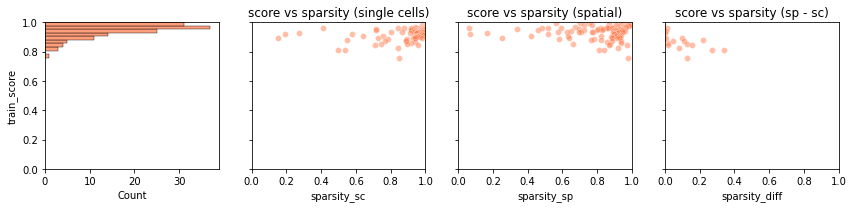

In [16]:
tg.plot_training_scores(ad_map, bins=10, alpha=.5)

In [17]:
control_markers = [
    'tfrc',
    'e2f2',
    'abcb4',
    'myh10',
    'podxl',
    'cd34',
    'sdc3',
    'pzp',
    'hc',
    'mrvi1',
    'gnaz',
    'vwf',
    'kdr',
    'stab2',
    'flt4',
    'col4a1'
]

In [18]:
sc.pp.neighbors(ad_ge)
sc.tl.umap(ad_ge)

         Falling back to preprocessing with `sc.pp.pca` and default params.


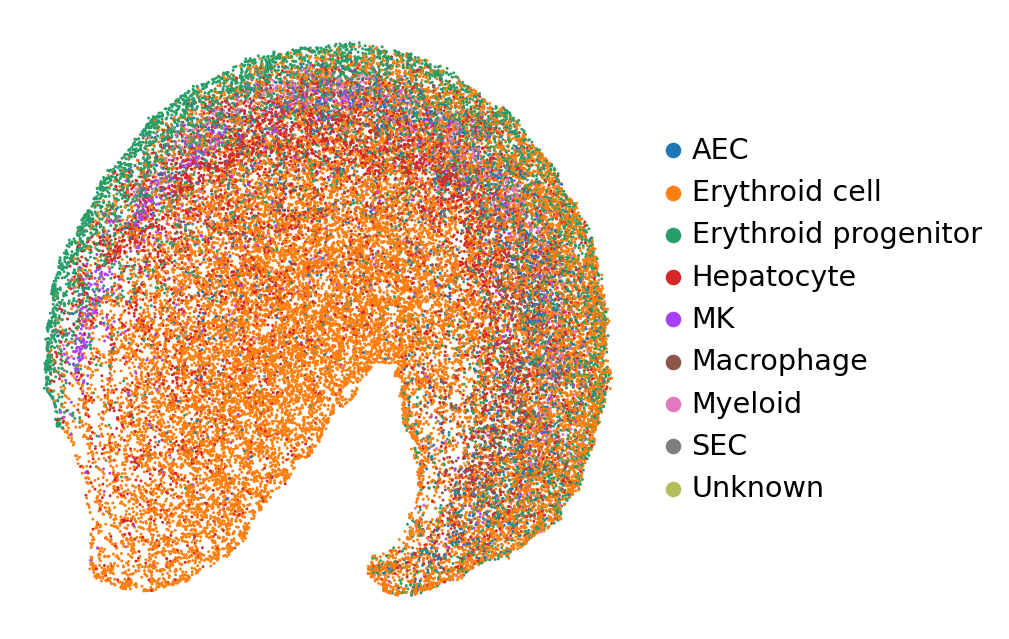

In [19]:

# Colorblindness adjusted vega_10
# See https://github.com/theislab/scanpy/issues/387
vega_10 = list(map(colors.to_hex, cm.tab10.colors))
vega_10_scanpy = vega_10.copy()
vega_10_scanpy[2] = '#279e68'  # green
vega_10_scanpy[4] = '#aa40fc'  # purple
vega_10_scanpy[8] = '#b5bd61'  # kakhi


plt.ioff()
sc.set_figure_params(scanpy=True, fontsize=14)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
)
sc.pl.umap(
    ad_ge, color='CellTypeID_new_preprocessed', ax=ax, size=7, show=False, title="", 
    palette=vega_10_scanpy, frameon=False
)
#plt.savefig('/storage/groups/ml01/workspace/anna.schaar/ncem/figures/sanity_check/' + 'umap_imputed.pdf')
plt.show()


In [20]:
np.unique(ad_ge.obs['CellTypeID_new_preprocessed'])

array(['AEC', 'Erythroid cell', 'Erythroid progenitor', 'Hepatocyte',
       'MK', 'Macrophage', 'Myeloid', 'SEC', 'Unknown'], dtype=object)

In [21]:
path = '.'
fn = 'merfish_wt_imputed_fetal_liver.h5ad'
#ad_ge.write(path + fn)

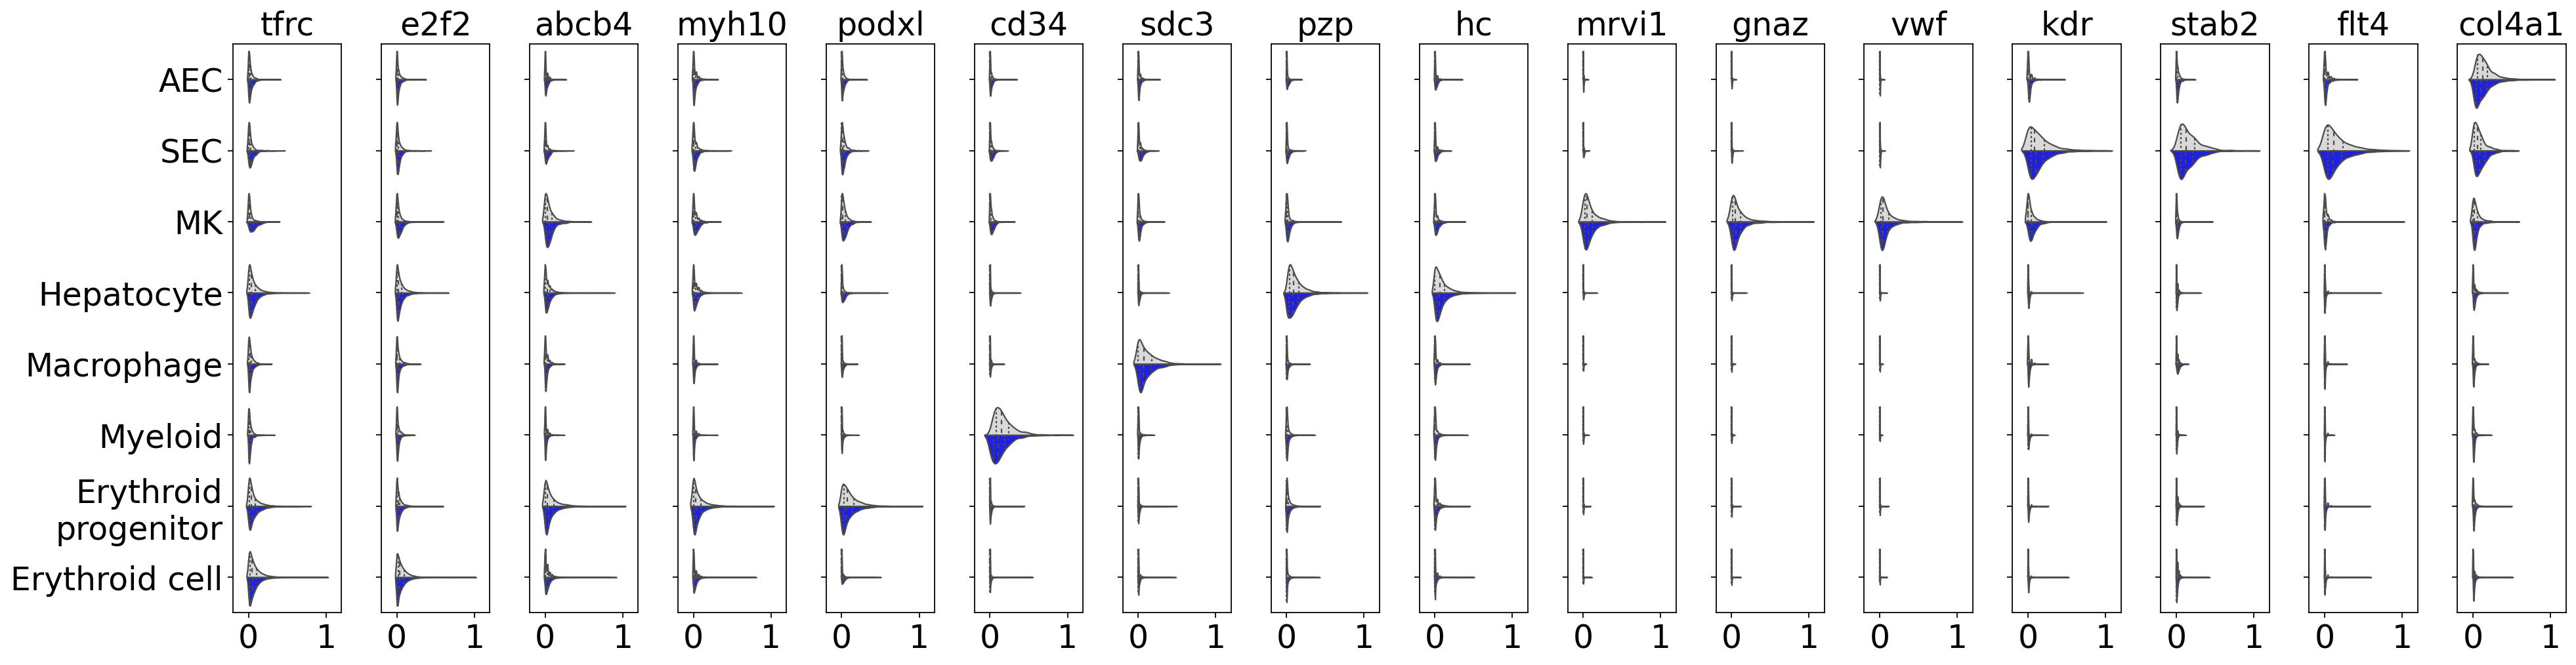

In [27]:
sc.set_figure_params(scanpy=True, fontsize=22)
fig, ax = plt.subplots(1,len(control_markers), figsize=(25,6.8), sharey=True)
for i, marker in enumerate(control_markers):
    merfish = pd.DataFrame(ad_sp[:, [marker]].X, columns=[marker])


    merfish = pd.DataFrame(
        merfish.stack()
    ).reset_index().rename(columns={'level_1': 'gene', 0: 'expression'})
    merfish['cell identity'] = list(ad_sp.obs['CellTypeID_new_preprocessed'])
    merfish['expression_level']=(merfish['expression']-merfish['expression'].min())/(merfish['expression'].max()-merfish['expression'].min())

    integrated = pd.DataFrame(ad_ge[:, [marker]].X, columns=[marker])

    integrated = pd.DataFrame(
        integrated.stack()
    ).reset_index().rename(columns={'level_1': 'gene', 0: 'expression'})
    integrated['cell identity'] = list(ad_ge.obs['CellTypeID_new_preprocessed'])
    integrated['expression_level']=(integrated['expression']-integrated['expression'].min())/(integrated['expression'].max()-integrated['expression'].min())

    merfish['sample'] = 'MERFISH'
    integrated['sample'] = 'imputed MERFISH'

    sanity_check = pd.concat([merfish, integrated])
    sanity_check = sanity_check[sanity_check['cell identity'] != 'Unknown']
    
    sanity_check=sanity_check.replace({'Erythroid progenitor': 'Erythroid\nprogenitor'})
    
    sorter = ['AEC', 'SEC', 'MK', 'Hepatocyte', 'Macrophage', 'Myeloid', 'Erythroid\nprogenitor', 'Erythroid cell']
    
    sanity_check['cell identity'] = sanity_check['cell identity'].astype("category")
    sanity_check['cell identity'].cat.set_categories(sorter, inplace=True)

    
    sns.violinplot(
        data=sanity_check.sort_values(by=['cell identity']), y='cell identity', 
        x='expression_level', inner="quart", hue="sample", 
        split=True, 
        linewidth=1, ax=ax[i],
        palette={"imputed MERFISH": "b", "MERFISH": ".85"},
    )
    ax[i].set_title(marker, fontsize=22)
    ax[i].grid(False)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend().remove()
    ax[i].set_xlim(-0.2, 1.2)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend('',frameon=False)

#plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig('/storage/groups/ml01/workspace/anna.schaar/ncem/figures/sanity_check/' + marker + '_new.pdf', bbox_inches='tight')
plt.show()

In [22]:
test_ad = ad_ge.copy()

In [23]:
#sc.pp.normalize_total(test_ad, target_sum=1e4)
sc.pp.log1p(test_ad)

In [29]:
ad_sp

AnnData object with n_obs × n_vars = 40864 × 132
    obs: 'CellID', 'FOV', 'CellTypeID_new', 'Center_x', 'Center_y', 'CellTypeID_new_preprocessed', 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'training_genes', 'overlap_genes'
    obsm: 'spatial', 'node_types'

In [26]:
test_ad.obsm = ad_sp.obsm

In [28]:
test_ad.uns = ad_sp.uns

In [29]:
test_ad

AnnData object with n_obs × n_vars = 40811 × 16187
    obs: 'CellID', 'FOV', 'CellTypeID_new', 'Center_x', 'Center_y', 'CellTypeID_new_preprocessed', 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'chozen_isoform', 'code', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'sparsity', 'is_training'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'training_genes', 'overlap_genes'
    obsm: 'spatial', 'node_types'

In [30]:
test_ad.write('/storage/groups/ml01/workspace/anna.schaar/ncem/data/lu/merfish_wt_imputed_fetal_liver.h5ad')

In [32]:
sc.pp.highly_variable_genes(test_ad)

In [33]:
sc.pp.neighbors(test_ad)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [34]:
sc.tl.umap(test_ad)

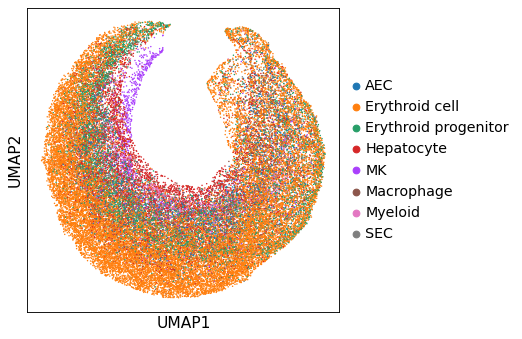

In [35]:
from typing import Mapping, Sequence
from matplotlib import cm, colors

# Colorblindness adjusted vega_10
# See https://github.com/theislab/scanpy/issues/387
vega_10 = list(map(colors.to_hex, cm.tab10.colors))
vega_10_scanpy = vega_10.copy()
vega_10_scanpy[2] = '#279e68'  # green
vega_10_scanpy[4] = '#aa40fc'  # purple
vega_10_scanpy[8] = '#b5bd61'  # kakhi

import matplotlib.pyplot as plt
plt.ioff()
sc.set_figure_params(scanpy=True, fontsize=14)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
)
sc.pl.umap(test_ad, color='CellTypeID_new_preprocessed', ax=ax, size=7, show=False, title="", palette=vega_10_scanpy)
#plt.savefig('/storage/groups/ml01/workspace/anna.schaar/ncem/figures/sanity_check/' + 'umap_imputed.pdf')
plt.show()